# Okabe Equation Impl.

## Sample Dataset

### Stations

In [10]:
import numpy as np

stations_np = np.array(
    np.meshgrid(
        range(0, 20001, 400),
        range(0, 20001, 400),
        [-0.1]), dtype='float32').T.reshape(-1, 3)

stations_np.shape

(2601, 3)

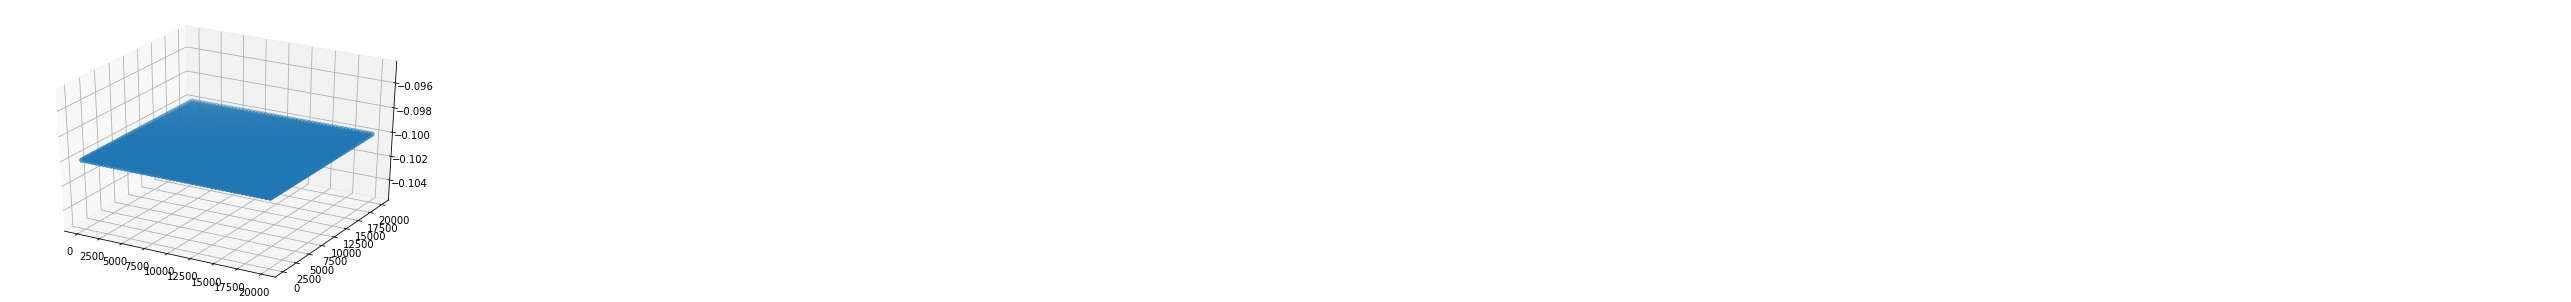

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

ax = Axes3D(plt.figure())
ax.scatter(stations_np[:, 0], stations_np[:, 1], stations_np[:, 2])

### Prisms

#### Cube Sign Constants

In [12]:
from itertools import product

import numpy as np

d_sets = [d for d in product((0., 1., ), repeat=3)]

signs_np = np.prod(
    np.power(-1, np.asarray(d_sets, dtype='float32') + 1), axis=1)
signs_np

array([-1.,  1.,  1., -1.,  1., -1., -1.,  1.], dtype=float32)

#### Locations, Indices, Rhos

In [14]:
import numpy as np

# Primitive gen.
def gen_locations(xs, ys, zs):
    return np.array(
        np.meshgrid(xs, ys, zs), dtype='float32').T.reshape(-1, 3)

def gen_rhos(n, rho_val):
    return np.full((n, ), rho_val, dtype='float32')

def gen_indices_list(n_xs, n_ys, n_zs, base_i=0):
    indices = []
    
    for xi in range(0, n_xs - 1):
        for yi in range(0, n_ys - 1):
            for zi in range(0, n_zs - 1):
                i_set = []
                for d_set in d_sets:
                    dxi, dyi, dzi = d_set
                    
                    i = yi + dyi
                    i += (xi + dxi) * n_ys
                    i += (zi + dzi) * n_ys * n_xs
                    i_set.append(base_i + i)
                indices.append(tuple(i_set))
    
    return np.asarray(indices, dtype='int32')

# Prism gen.
def concat_prisms(xs, ys, zs, rho_val, prev_locs=None, prev_indices=None, prev_rhos=None):
    locs = gen_locations(xs, ys, zs)
    indices = gen_indices_list(
        len(xs), len(ys), len(zs),
        base_i=len(prev_locs) if prev_locs is not None else 0)
    rhos = gen_rhos(len(indices), rho_val)
    
    if prev_locs is not None:
        locs = np.concatenate((prev_locs, locs, ))
    if prev_indices is not None:
        indices = np.concatenate((prev_indices, indices, ))
    if prev_rhos is not None:
        rhos = np.concatenate((prev_rhos, rhos, ))
    
    return (locs, indices, rhos, )

# Generate instances
prism_locs_np, prism_indices_np, prism_rhos_np = concat_prisms(
    range(8500, 13501, 500),
    range(1500, 14001, 500),
    range(1500, 1751, 250),
    2180.)

prism_locs_np, prism_indices_np, prism_rhos_np = concat_prisms(
    range(8500, 17501, 500),
    range(1500, 14001, 500),
    range(2000, 3251, 250),
    2180.,
    prism_locs_np, prism_indices_np, prism_rhos_np)

prism_locs_np, prism_indices_np, prism_rhos_np = concat_prisms(
    range(3000, 5001, 500),
    range(4000, 13001, 500),
    range(2000, 2501, 250),
    2180.,
    prism_locs_np, prism_indices_np, prism_rhos_np)

prism_locs_np.shape

(3821, 3)

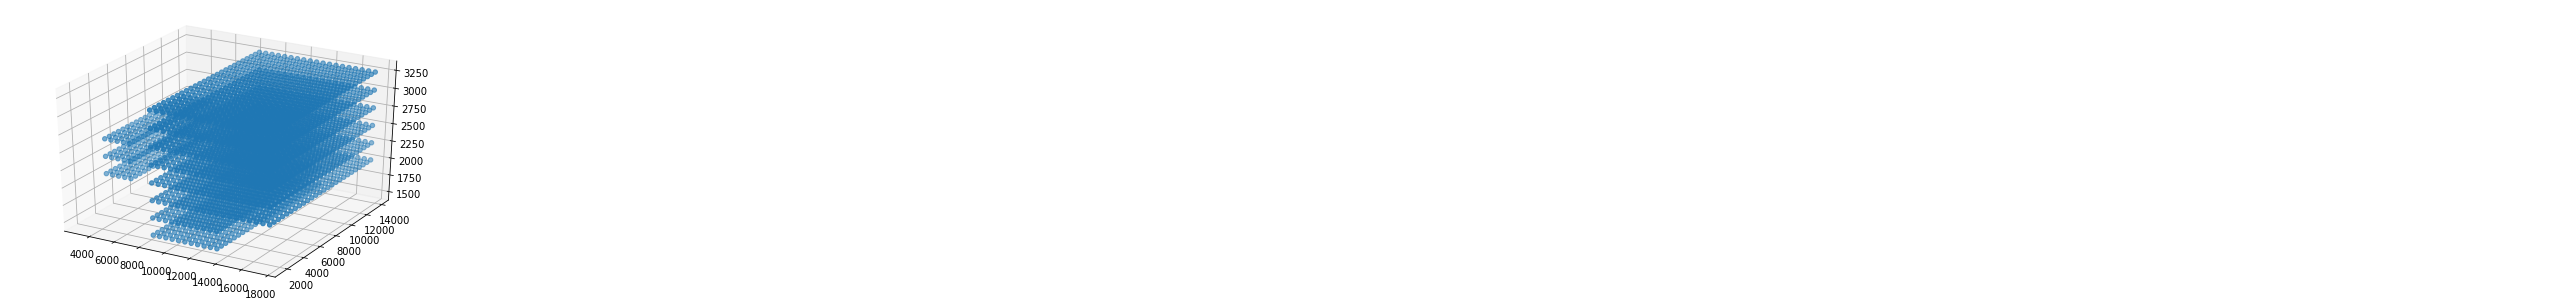

In [15]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# c = ["blue" if (i in prism_indices_np[2499]) else "red" for i in range(0, len(prism_locs_np))]

ax = Axes3D(plt.figure())
ax.scatter(prism_locs_np[:, 0], prism_locs_np[:, 1], prism_locs_np[:, 2])

## Calculation

### Tools

In [ ]:
import tensorflow as tf

def pairwise_dist(a, b):
    with tf.variable_scope('pairwise_dist'):
        na = tf.reduce_sum(tf.square(a), axis=1)
        nb = tf.reduce_sum(tf.square(b), axis=1)
        
        na = tf.reshape(na, [-1, 1])
        nb = tf.reshape(nb, [1, -1])
        
        d = tf.sqrt(tf.maximum(na - 2*tf.matmul(a, b, transpose_b=True) + nb, 0.0))
    return d

### Generate Dataflow

In [ ]:
import tensorflow as tf

# tf.enable_eager_execution()
# tf.reset_default_graph()

# Prepare stations
stations = tf.convert_to_tensor(stations_np)

# Prepare prisms
prism_locs = tf.convert_to_tensor(prism_locs_np)
prism_locs_x = prism_locs[:, 0]
prism_locs_y = prism_locs[:, 1]
prism_locs_z = prism_locs[:, 2]

signs = tf.convert_to_tensor(signs_np)

prism_indices = tf.convert_to_tensor(prism_indices_np)
prism_rhos = tf.convert_to_tensor(prism_rhos_np)

# Pairwise distances between stations and locations
rs = pairwise_dist(stations, prism_locs)

# Calculate Okabe prop. per locations
dxs = stations[:, 0:1] - prism_locs_x
dys = stations[:, 1:2] - prism_locs_y
dzs = stations[:, 2:3] - prism_locs_z

os = (dxs + dys + rs) / dzs
ds_without_mu = dxs*tf.log(dys+rs) + dys*tf.log(dxs+rs) + 2*dzs*tf.atan(os)

# 
stations_pre_ds = tf.gather(pre_ds, prism_indices, axis=1)
stations_ds = stations_pre_ds * tf.reshape(signs, (1, 1, signs.get_shape()[0]))

a = tf.reduce_sum(stations_ds, axis=2)
stations_g = tf.reduce_sum(a, axis=1)

# Calculate stations
# mnk_const = tf.constant(-6.67384 * 10**-6)

# prisms_r = prisms_rho - (1400 + (172 * prisms_zf**0.21))
# prisms_g = mnk_const * prisms_r * prisms_d_sum

# stations_g = tf.reduce_sum(prisms_g, axis=1)

### Calculate

In [ ]:
import tensorflow as tf

with tf.Session() as session:
    %time out = session.run(stations_g)
out